> 파일 명 : 사용알고리즘_이진(bin)/다중(multi)_데이터셋명

## KNN 이진분류
- 오렌지와 그레이프후르츠의 분류

### 0. 필요한 라이브러리 import

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. 데이터 로딩
보통 하드디스크에 파일을 저장해서 사용한다.

In [251]:
citrus = pd.read_csv('citrus.csv')
citrus.shape

(10000, 6)

In [252]:
df = citrus.copy()
df.head(10)

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
5,orange,4.59,95.86,142,100,2
6,orange,4.64,97.94,156,85,2
7,orange,4.65,98.50,142,74,2
8,orange,4.68,100.20,159,90,16
9,orange,4.69,100.31,161,76,6


In [253]:
df.info() # 각 칼럼들의 데이터 타입을 확인하기 위해서

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [254]:
df.isna().sum(axis=0) # 결측치 확인

name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64

In [255]:
df.describe().T # 최대, 최소를 평균과 비교하여 miss 값을 확인

,count,mean,std,min,25%,50%,75%,max
diameter,10000.0,9.975685,1.947844,2.96,8.46,9.980,11.4800,16.45
weight,10000.0,175.050792,29.212119,86.76,152.22,174.985,197.7225,261.51
red,10000.0,153.847800,10.432954,115.00,147.00,154.000,161.0000,192.00
green,10000.0,76.010600,11.708433,31.00,68.00,76.000,84.0000,116.00
blue,10000.0,11.363200,9.061275,2.00,2.00,10.000,17.0000,56.00


In [256]:
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


타겟값이 Name이다. -> 타깃값의 분포를 보자.

In [257]:
# 타겟값의 개수
df['name'].value_counts()

orange        5000
grapefruit    5000
Name: name, dtype: int64

데이터가 기울어지지 않았다. -> 학습이 가능하다.

<Axes: xlabel='name', ylabel='count'>

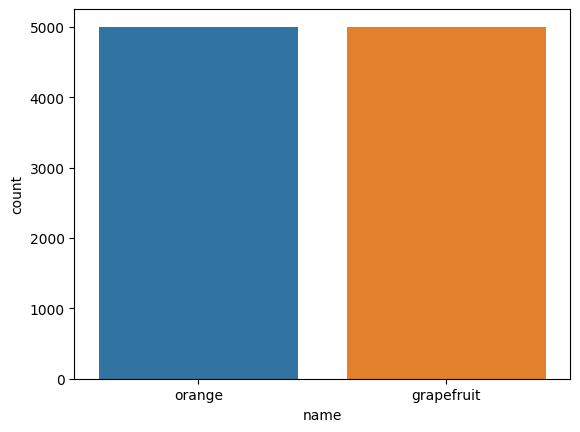

In [258]:
# 막대그래프를 그려보자
sns.countplot(data=df, x='name')

In [259]:
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


### 2. 테스트 데이터를 분리


**가장 기본적인 방법**
- 슬라이싱하자
  - 위에서 일부, 밑에서 일부

In [260]:
len(df) * 0.8

8000.0

8000개를 테스트 데이터로, 2000개를 학습 데이터로

우선 위에 오렌지, 밑에 자몽이므로 이를 섞자.



sample 사용

-> 랜덤으로 데이터를 섞는다.

In [261]:
df = df.sample(frac=1)
df.head()

,name,diameter,weight,red,green,blue
6318,grapefruit,10.71,185.17,140,70,12
4804,orange,10.74,185.18,167,96,15
661,orange,7.07,132.38,148,74,6
6649,grapefruit,10.92,188.97,158,57,4
8958,grapefruit,12.49,212.90,143,70,30


In [262]:
df.columns

Index(['name', 'diameter', 'weight', 'red', 'green', 'blue'], dtype='object')

입력, 출력값을 뽑아내자.
- x : 입력
- y : 출력

In [263]:
x = df[['diameter', 'weight', 'red', 'green', 'blue']]
y = df['name']

In [264]:
x.head() # Name이 사라졌는지 확인

,diameter,weight,red,green,blue
6318,10.71,185.17,140,70,12
4804,10.74,185.18,167,96,15
661,7.07,132.38,148,74,6
6649,10.92,188.97,158,57,4
8958,12.49,212.90,143,70,30


In [265]:
y.head() # Name만 남아있는지 확인

6318    grapefruit
4804        orange
661         orange
6649    grapefruit
8958    grapefruit
Name: name, dtype: object

테스트와 학습용을 분리하자.

In [266]:
idx = int(len(x) * 0.8)
idx

8000

위에 8000개만 x_train
2000개는 x_test

In [267]:
x_train = x.iloc[:idx, :]
x_test = x.iloc[idx:, :]

In [268]:
x_train.shape, x_test.shape

((8000, 5), (2000, 5))

마찬가지로 y도 분리하자.

(y는 칼럼이 하나이므로 바로 슬라이싱 가능)

In [269]:
y_train = y[:idx]
y_test = y[idx:]

In [270]:
y_train.shape, y_test.shape

((8000,), (2000,))

> 이제 x_test, y_test는 다루지 않는다.

x_train과 y_train만 다루자

In [271]:
x_train.head()

,diameter,weight,red,green,blue
6318,10.71,185.17,140,70,12
4804,10.74,185.18,167,96,15
661,7.07,132.38,148,74,6
6649,10.92,188.97,158,57,4
8958,12.49,212.90,143,70,30


### 3. 스케일링

- 표준화
  - ![](https://t1.daumcdn.net/cfile/tistory/2577E53F57D6C56A28)
- 칼럼 단위로 평균을 구하자

diameter 칼럼의 평균을 구하자

In [272]:
u_d = x_train['diameter'].mean() # 평균
std_d = x_train['diameter'].std() # 표준편차

In [273]:
x_train['diameter'] = (x_train['diameter']- u_d )/std_d

<ipython-input-273-a63e7e5bff79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['diameter'] = (x_train['diameter']- u_d )/std_d


In [274]:
x_train.head()

,diameter,weight,red,green,blue
6318,0.386788,185.17,140,70,12
4804,0.402161,185.18,167,96,15
661,-1.478477,132.38,148,74,6
6649,0.494400,188.97,158,57,4
8958,1.298923,212.90,143,70,30


나머지도 표준화를 시키자.

In [275]:
u_w = x_train['weight'].mean() # 평균
std_w = x_train['weight'].std() # 표준편차
x_train['weight'] = (x_train['weight']- u_w )/std_w

u_r = x_train['red'].mean() # 평균
std_r = x_train['red'].std() # 표준편차
x_train['red'] = (x_train['red']- u_r )/std_r

u_g = x_train['green'].mean() # 평균
std_g = x_train['green'].std() # 표준편차
x_train['green'] = (x_train['green']- u_g )/std_g

u_b = x_train['blue'].mean() # 평균
std_b = x_train['blue'].std() # 표준편차
x_train['blue'] = (x_train['blue']- u_b )/std_b

<ipython-input-275-682825eff756>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['weight'] = (x_train['weight']- u_w )/std_w
<ipython-input-275-682825eff756>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['red'] = (x_train['red']- u_r )/std_r
<ipython-input-275-682825eff756>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

변수명을 동일하게 하면 안 된다.

평균하고 표준편차는 test 단계에서 적용해야 한다.

> 변수를 살리기 위해 이름을 다 붙이자.

In [276]:
x_train.head()

,diameter,weight,red,green,blue
6318,0.386788,0.356095,-1.331716,-0.512695,0.080010
4804,0.402161,0.356436,1.263917,1.706488,0.412119
661,-1.478477,-1.447081,-0.562639,-0.171283,-0.584206
6649,0.494400,0.485893,0.398706,-1.622287,-0.805612
8958,1.298923,1.303283,-1.043312,-0.512695,2.072661


#### 레이블 인코딩

In [277]:
y_train

6318    grapefruit
4804        orange
661         orange
6649    grapefruit
8958    grapefruit
           ...    
2164        orange
9929    grapefruit
640         orange
1265        orange
6231    grapefruit
Name: name, Length: 8000, dtype: object

y_train의 grapefruit를 0으로, orange를 1로 바꾸자.

In [278]:
y_train = y_train.map({'grapefruit':0, 'orange':1})
y_train

6318    0
4804    1
661     1
6649    0
8958    0
       ..
2164    1
9929    0
640     1
1265    1
6231    0
Name: name, Length: 8000, dtype: int64

### 4. 학습
- 베이스라인 학습

In [279]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier() # 기본적으로 5개
clf.fit(x_train, y_train) # 학습을 시키는 함수

KNeighborsClassifier()

평가

In [280]:
x_test.head()

,diameter,weight,red,green,blue
4743,10.55,183.03,165,85,12
6762,10.99,190.05,154,82,18
8049,11.81,202.95,155,72,4
2815,8.69,155.58,150,79,2
5985,10.43,180.81,142,79,16


x의 Test 데이터도 스케일링하자

In [281]:
x_test['diameter'] = (x_test['diameter']- u_d )/std_d
x_test['weight'] = (x_test['weight']- u_w )/std_w
x_test['red'] = (x_test['red']- u_r )/std_r
x_test['green'] = (x_test['green']- u_g )/std_g
x_test['blue'] = (x_test['blue']- u_b )/std_b

<ipython-input-281-320f868c8cd4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['diameter'] = (x_test['diameter']- u_d )/std_d
<ipython-input-281-320f868c8cd4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['weight'] = (x_test['weight']- u_w )/std_w
<ipython-input-281-320f868c8cd4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [282]:
y_test

4743        orange
6762    grapefruit
8049    grapefruit
2815        orange
5985    grapefruit
           ...    
5772    grapefruit
8577    grapefruit
4479        orange
8293    grapefruit
2540        orange
Name: name, Length: 2000, dtype: object

y_test도 인코딩하자

In [283]:
y_test = y_test.map({'grapefruit':0, 'orange':1})
y_test

4743    1
6762    0
8049    0
2815    1
5985    0
       ..
5772    0
8577    0
4479    1
8293    0
2540    1
Name: name, Length: 2000, dtype: int64

값을 예측하자 => 예측값

In [284]:
y_pred = clf.predict(x_test)
y_pred

array([1, 0, 0, ..., 1, 0, 1])

정답은 y_test, 예측값은 y_pred

In [285]:
y_test = y_test.values
y_test

array([1, 0, 0, ..., 1, 0, 1])

### 5. 혼동행렬

In [286]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test, y_pred)
cfm

array([[966,  91],
       [ 72, 871]])

heatmap

: 사각형 맵

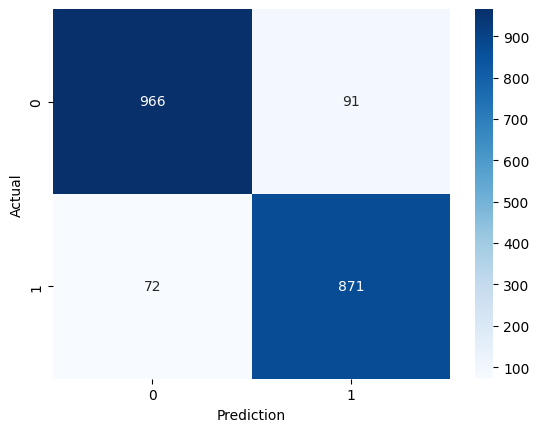

In [287]:
s = sns.heatmap(cfm, annot=True, cmap='Blues', fmt='d', cbar='False')
s.set(xlabel='Prediction', ylabel='Actual')
plt.show()

계산
- 정답먼저, 예측값 뒤

In [288]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def print_matrics(y_test, y_pred):
  acc = accuracy_score(y_test, y_pred)
  re = recall_score(y_test, y_pred)
  pr = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print('정확도:', acc)
  print('재현율:', np.around(re, 4))
  print('정밀도:', np.around(pr, 4))
  print('f1:', np.around(f1, 4))

In [289]:
print_matrics(y_test, y_pred)

정확도: 0.9185
재현율: 0.9236
정밀도: 0.9054
f1: 0.9144


### 6. 튜닝

In [290]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train, y_train)

KNeighborsClassifier()

In [291]:
# 정확도들을 저장할 배열
scores = []

In [292]:
# 3개부터 100까지 k(데이터 개수)를 바꿔가며 모델을 테스트
for k in range(3, 101):
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  acc = accuracy_score(y_test, y_pred)
  scores.append(acc)

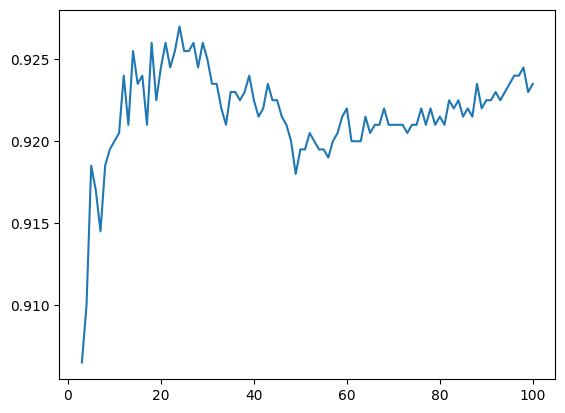

In [293]:
# 그래프를 그려서 정확도를 확인하자
plt.plot(range(3,101), scores)
plt.show()

#### 베스트 모델
- 가장 높은 정확도를 가지는 걸 찾아 돌린다.

In [294]:
clf = KNeighborsClassifier(n_neighbors=30)
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=30)

#### 그리드 서치

- 그리드 서치는 오래걸리므로, 랜덤 서치라는 방법도 있기는 하다.

In [295]:
%%time

from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors':list(range(3, 100)),
    'algorithm' : ['ball_tree', 'kd_tree', 'brute']
}

clf = KNeighborsClassifier()
grid = GridSearchCV(clf, grid_params, cv=5) # 데이터를 5등분한다.
grid.fit(x_train, y_train)

CPU times: user 3min 49s, sys: 1.47 s, total: 3min 50s
Wall time: 3min 20s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, 32, ...]})

학습이 끝나고 나면 어떤 결과가 가장 좋았는지 나온다. (grid 서치에 따른 정확도를 기준)

In [296]:
print('Best parameter:', grid.best_params_)
print('Best score:', grid.best_score_)

Best parameter: {'algorithm': 'ball_tree', 'n_neighbors': 37}
Best score: 0.928875


이 Best Parameter에 맞게 다시 학습시킨다.

In [297]:
clf = KNeighborsClassifier(n_neighbors=32, algorithm='ball_tree')
clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=32)

In [298]:
# 데이터의 정확도
y_pred = clf.predict(x_test)
print_matrics(y_test, y_pred)

정확도: 0.9235
재현율: 0.9321
정밀도: 0.9081
f1: 0.9199
